# **Análisis del Vecino mas Cercano**

El análisis de vecino más cercano es una técnica que se utiliza para **evaluar la proximidad espacial entre elementos geográficos**. En esencia, busca identificar el vecino más cercano a cada entidad geoespacial en un conjunto de datos, **calculando la distancia entre ellas**. Esta distancia puede determinarse utilizando diversas métricas, como la **distancia euclidiana** o la **distancia de Manhattan**, según la naturaleza de los datos y los objetivos del análisis.

## **1. Problema**

En este estudio, nos proponemos abordar la problemática fundamental relacionada con la respuesta a emergencias en la ciudad de Lima Metropolitana. En específico, nos enfocaremos en realizar un análisis de los vecinos más cercanos entre las instituciones educativas y las comisarías. El objetivo principal es determinar cuál es la comisaría más próxima para responder eficazmente a cualquier emergencia que pueda surgir en las proximidades de cada institución educativa.

## **2. Objetivo**

* Determinar de manera precisa y eficiente cuál es la comisaría más cercana a cada institución educativa en la ciudad de Lima Metropolitana

## **3. Fuente de datos**

Para la elaboración de este tutorial, se han obtenido los conjuntos de datos de las siguientes fuentes de datos abiertos.

* Comisarias: [Directorios de comisarias](https://www.mininter.gob.pe/ubica-tu-comisaria) del Ministerio del Interior del Perú
* Instituciones educativas: [Estadisticas de la calidad educativa](https://escale.minedu.gob.pe/padron-de-iiee) del Ministerio de Educación del Perú

## **4. Procedimiento**

El análisis se llevará a cabo mediante Python y sus librerías especializadas en el manejo de datos geoespaciales y visualización. El objetivo es demostrar de manera clara y concisa cómo este tipo de análisis puede explorarse y analizarse eficientemente en un entorno de programación.

### **4.1. Lectura de datos**

Antes de iniciar con la lectura de los datos es necesario importar todas las librerías a utilizar:

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import contextily as cx
import matplotlib.pyplot as plt
plt.style.use('ggplot')

A continuación, procederemos a la lectura de los conjuntos de datos que emplearemos en este análisis. Las comisarías se presentan en formato Shapefile, mientras que las instituciones educativas se encuentran en valores separados por coma (csv). Para realizar esta tarea, utilizaremos las librerías `geopandas` y `pandas` para la lectura de cada uno, respectivamente.

In [2]:
# Lectura de comisarias
gdfComisarias = gpd.read_file('data/comisarias_peru.shp')

# Lectura de colegios
dfColegios = pd.read_csv('data/Padron_web.zip', encoding='UTF-8', sep=',', low_memory=False)

Visualizaremos los datos:

In [3]:
# Visualizar comisarias
gdfComisarias.head(3)

,id,nombre,departamen,provincia,distrito,ubigeo,lon,lat,geometry
0,32,COMISARIA INDIANA,LORETO,MAYNAS,INDIANA,160104,-73.042052,-3.499631,POINT (-73.04205 -3.49963)
1,33,COMISARIA RURAL SINCHICUY,LORETO,MAYNAS,INDIANA,160104,-73.139910,-3.588879,POINT (-73.13991 -3.58888)
2,34,COMISARIA FRANCISCO DE ORELLANA,LORETO,MAYNAS,LAS AMAZONAS,160105,-72.764743,-3.422353,POINT (-72.76474 -3.42235)


In [4]:
# Visualizar colegios
dfColegios.head(3)

,COD_MOD,ANEXO,CODLOCAL,CEN_EDU,NIV_MOD,D_NIV_MOD,D_FORMA,COD_CAR,D_COD_CAR,TIPSSEXO,...,COD_TUR,D_COD_TUR,ESTADO,D_ESTADO,D_FTE_DATO,TALUM_HOM,TALUM_MUJ,TALUMNO,TDOCENTE,TSECCION
0,2723696,0,NaN,MIS PRIMEROS PASOS 4,A5,Inicial - Programa no escolarizado,No escolarizada,a,No aplica,3,...,11,Mañana,1,Activa,Declarado,5,5,10,0,1
1,2723695,0,NaN,MIS PRIMEROS PASOS 3,A5,Inicial - Programa no escolarizado,No escolarizada,a,No aplica,3,...,11,Mañana,1,Activa,Declarado,4,4,8,0,1
2,1008614,0,725808.0,DON BOSCO,F0,Secundaria,Escolarizada,a,No aplica,3,...,11,Mañana,1,Activa,Declarado,28,29,57,10,5


### **4.2. Preprocesamiento de los datos**

**Filtro de columnas**

La capa de colegios contiene muchas columnas, vamos a listar los nombres para visualizar solo las columnas que contienen las coordenadas.

In [5]:
# Visualizar columnas de colegios
dfColegios.columns.values

array(['COD_MOD', 'ANEXO', 'CODLOCAL', 'CEN_EDU', 'NIV_MOD', 'D_NIV_MOD',
       'D_FORMA', 'COD_CAR', 'D_COD_CAR', 'TIPSSEXO', 'D_TIPSSEXO',
       'GESTION', 'D_GESTION', 'GES_DEP', 'D_GES_DEP', 'DIRECTOR',
       'TELEFONO', 'EMAIL', 'PAGWEB', 'DIR_CEN', 'REFERENCIA',
       'LOCALIDAD', 'CODCP_INEI', 'CODCCPP', 'CEN_POB', 'AREA_CENSO',
       'DAREACENSO', 'CODGEO', 'D_DPTO', 'D_PROV', 'D_DIST', 'D_REGION',
       'CODOOII', 'D_DREUGEL', 'NLAT_IE', 'NLONG_IE', 'TIPOPROG',
       'D_TIPOPROG', 'COD_TUR', 'D_COD_TUR', 'ESTADO', 'D_ESTADO',
       'D_FTE_DATO', 'TALUM_HOM', 'TALUM_MUJ', 'TALUMNO', 'TDOCENTE',
       'TSECCION'], dtype=object)

Tras realizar una revisión, se observa que la capa no cuenta con un campo identificador (ID). Por lo tanto, procederemos a construir uno:

In [6]:
dfColegios['ID_CEN_EDU'] = dfColegios.index + 1

Finalmente, seleccionaremos solo aquellas columnas de interes para el análisis

In [7]:
dfColegios = dfColegios[['ID_CEN_EDU','CODLOCAL','CEN_EDU','D_DPTO','D_PROV','D_DIST','NLAT_IE','NLONG_IE']]
dfColegios.head()

,ID_CEN_EDU,CODLOCAL,CEN_EDU,D_DPTO,D_PROV,D_DIST,NLAT_IE,NLONG_IE
0,1,NaN,MIS PRIMEROS PASOS 4,LIMA,LIMA,SAN LUIS,-12.07358,-76.99879
1,2,NaN,MIS PRIMEROS PASOS 3,LIMA,LIMA,SAN LUIS,-12.07357,-76.99879
2,3,725808.0,DON BOSCO,LIMA,LIMA,SAN LUIS,-12.08059,-77.00386
3,4,81077.0,VILLA MARIA,LIMA,LIMA,SAN LUIS,-12.08064,-77.00396
4,5,NaN,MIS PRIMEROS PASOS 1,LIMA,LIMA,SAN LUIS,-12.07358,-76.99878


**Conversión de datos**

El siguiente paso implica la conversión del DataFrame de Colegios en un GeoDataFrame, para lo cual emplearemos las funciones de geopandas: **[geopandas.points_from_xy](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)** y **[geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html)**.

Iniciaremos la creación de un arreglo de geometrías utilizando la función **`points_from_xy`**:

In [8]:
geometry = gpd.points_from_xy(x=dfColegios.NLONG_IE, y=dfColegios.NLAT_IE, crs='EPSG:4326')

Ahora procederemos a convertir el DataFrame de colegios en un GeoDataFrame mediante el uso de la función **`GeoDataFrame`**. Dicha función solicita dos parámetros: uno que contenga los datos o atributos (puede ser un DataFrame), y el otro que incluya las geometrías, como un arreglo de geometrías.

In [9]:
gdfColegios = gpd.GeoDataFrame(dfColegios, geometry=geometry)
gdfColegios.head(3)

,ID_CEN_EDU,CODLOCAL,CEN_EDU,D_DPTO,D_PROV,D_DIST,NLAT_IE,NLONG_IE,geometry
0,1,NaN,MIS PRIMEROS PASOS 4,LIMA,LIMA,SAN LUIS,-12.07358,-76.99879,POINT (-76.99879 -12.07358)
1,2,NaN,MIS PRIMEROS PASOS 3,LIMA,LIMA,SAN LUIS,-12.07357,-76.99879,POINT (-76.99879 -12.07357)
2,3,725808.0,DON BOSCO,LIMA,LIMA,SAN LUIS,-12.08059,-77.00386,POINT (-77.00386 -12.08059)


**Filtro de registros**

Dado que únicamente requerimos los datos correspondientes a las provincias de Lima y Callao, procederemos a realizar un filtro en nuestros datos para seleccionar exclusivamente esta información.

In [10]:
# Filtrar comisarias
gdfComLima = gdfComisarias.loc[gdfComisarias.provincia.isin(['LIMA','CALLAO'])]
gdfComLima.shape

(147, 9)

In [11]:
# Filtrar colegios
gdfColLima = gdfColegios.loc[gdfColegios.D_PROV.isin(['LIMA','CALLAO'])]
gdfColLima.shape

(13512, 9)

**Reproyectar**

Realizar la proyección de las capas a WGS84 Zona 18 Sur (EPSG:32718).

In [12]:
gdfComLima = gdfComLima.to_crs(epsg=32718)
gdfColLima = gdfColLima.to_crs(epsg=32718)

Verificar la proyección de ambas capas:

In [13]:
print(f'CRS Comisarias {gdfComLima.crs}')
print(f'CRS Colegios {gdfColLima.crs}')

CRS Comisarias EPSG:32718
CRS Colegios EPSG:32718


### **4.3. Análisis del Vecino mas cercano**

Antes de comenzar el análisis, crearemos en el GeoDataFrame de comisarías un campo de tipo texto que contendrá las geometrías almacenadas en formato **WKT**. Esta información será utilizada más adelante para construir un nuevo GeoDataFrame que incluirá el segmento de línea entre los colegios y la comisaría más cercana.

In [14]:
gdfComLima['pointCom'] = gdfComLima['geometry']

Utilizando la función **[sjoin_nearest](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html)**  de geopandas vamos a realizar una unión espacial entre la capa de colegios y comisarías.

In [15]:
gdfNearLine = gpd.sjoin_nearest(gdfColLima[['ID_CEN_EDU','CODLOCAL','CEN_EDU','D_DPTO','D_PROV','D_DIST', 'geometry']], 
                                gdfComLima[['id','nombre','pointCom','geometry']],
                                distance_col = 'distancia',
                                lsuffix='L',
                                rsuffix='R')

del gdfNearLine['index_R']

Visualizar los resultados

In [16]:
gdfNearLine.head()

,ID_CEN_EDU,CODLOCAL,CEN_EDU,D_DPTO,D_PROV,D_DIST,geometry,id,nombre,pointCom,distancia
0,1,NaN,MIS PRIMEROS PASOS 4,LIMA,LIMA,SAN LUIS,POINT (282432.188 8664515.986),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),94.548358
1,2,NaN,MIS PRIMEROS PASOS 3,LIMA,LIMA,SAN LUIS,POINT (282432.180 8664517.092),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),94.085419
2,3,725808.0,DON BOSCO,LIMA,LIMA,SAN LUIS,POINT (281885.791 8663736.359),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),939.573068
3,4,81077.0,VILLA MARIA,LIMA,LIMA,SAN LUIS,POINT (281874.943 8663730.747),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),949.804747
4,5,NaN,MIS PRIMEROS PASOS 1,LIMA,LIMA,SAN LUIS,POINT (282433.277 8664515.994),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),95.536065


Y listo, como se observa se ha identificado cual es la comisaria mas cercana a cada Colegio.

### **4.4. Construir lineas entre vecinos mas cercanos**

A continuación, procederemos a construir un GeoDataFrame que contendrá geometrías de tipo líneas, las cuales conectarán cada colegio con la comisaría más cercana. Para llevar a cabo este proceso, utilizaremos el GeoDataFrame `gdfNearLine`, junto con los campos `geometry` y `pointCom`, empleando además la función **`LineString`** proveniente de la biblioteca **Shapely**.

In [17]:
gdfNearLine['geometry_line'] = gdfNearLine.apply(lambda row: LineString([row['geometry'],row['pointCom']]), axis=1)

Para finalizar, procederemos a actualizar la geometría, indicando que la nueva forma geométrica se alojará en el campo **`geometry_line`**.

In [18]:
gdfNearLine.set_geometry('geometry_line', crs='EPSG:32718', inplace=True)

Visualizamos los atributos:

In [19]:
gdfNearLine.head(3)

,ID_CEN_EDU,CODLOCAL,CEN_EDU,D_DPTO,D_PROV,D_DIST,geometry,id,nombre,pointCom,distancia,geometry_line
0,1,NaN,MIS PRIMEROS PASOS 4,LIMA,LIMA,SAN LUIS,POINT (282432.188 8664515.986),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),94.548358,"LINESTRING (282432.188 8664515.986, 282346.236..."
1,2,NaN,MIS PRIMEROS PASOS 3,LIMA,LIMA,SAN LUIS,POINT (282432.180 8664517.092),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),94.085419,"LINESTRING (282432.180 8664517.092, 282346.236..."
2,3,725808.0,DON BOSCO,LIMA,LIMA,SAN LUIS,POINT (281885.791 8663736.359),673,COMISARIA SAN LUIS,POINT (282346.236 8664555.375),939.573068,"LINESTRING (281885.791 8663736.359, 282346.236..."


## **5. Resultados**

A continuación, procederemos a calcular las distancias mínimas, máximas y medias desde los colegios hasta las comisarías más cercanas, centrándonos en esta evaluación a nivel de distrito. Este proceso brindará una perspectiva completa de la proximidad entre los centros educativos y las comisarías en cada municipio.

In [20]:
# Agrupando y calculando valores max, min y promedio por distrito
gdfRep = gdfNearLine.groupby(['D_DIST','D_PROV','D_DPTO'])\
                    .agg({'distancia':[min,max,'mean']})\
                    .reset_index()

# Renombrar columnas:
gdfRep.columns = list(map('_'.join, gdfRep.columns.values))

# Ordenar columnas por el promedio de mayor a menos
gdfRep.sort_values(by='distancia_mean', ascending=False)

,D_DIST_,D_PROV_,D_DPTO_,distancia_min,distancia_max,distancia_mean
10,CIENEGUILLA,LIMA,LIMA,117.366793,8676.712484,3161.313802
31,PUNTA HERMOSA,LIMA,LIMA,320.461551,7858.173749,2843.794036
27,PACHACAMAC,LIMA,LIMA,29.057960,6175.552735,2202.402319
6,CARABAYLLO,LIMA,LIMA,40.589519,13888.839552,2191.761812
0,ANCON,LIMA,LIMA,70.295993,5821.136951,2185.783353
22,LURIGANCHO,LIMA,LIMA,60.603013,5339.737847,2006.764929
8,CHACLACAYO,LIMA,LIMA,173.691354,3876.169925,2006.640734
30,PUENTE PIEDRA,LIMA,LIMA,34.921697,3853.402583,1607.572113
28,PUCUSANA,LIMA,LIMA,45.730198,5355.865346,1515.710822
23,LURIN,LIMA,LIMA,35.350361,3405.771448,1447.249279


Como se observa, en un conjunto de 25 municipios, la distancia promedio entre un colegio y la comisaría supera el kilómetro, y en 9 de ellos, dicha distancia promedio excede los 1.5 kilómetros. Con el propósito de identificar posibles patrones, examinemos gráficamente esta situación:

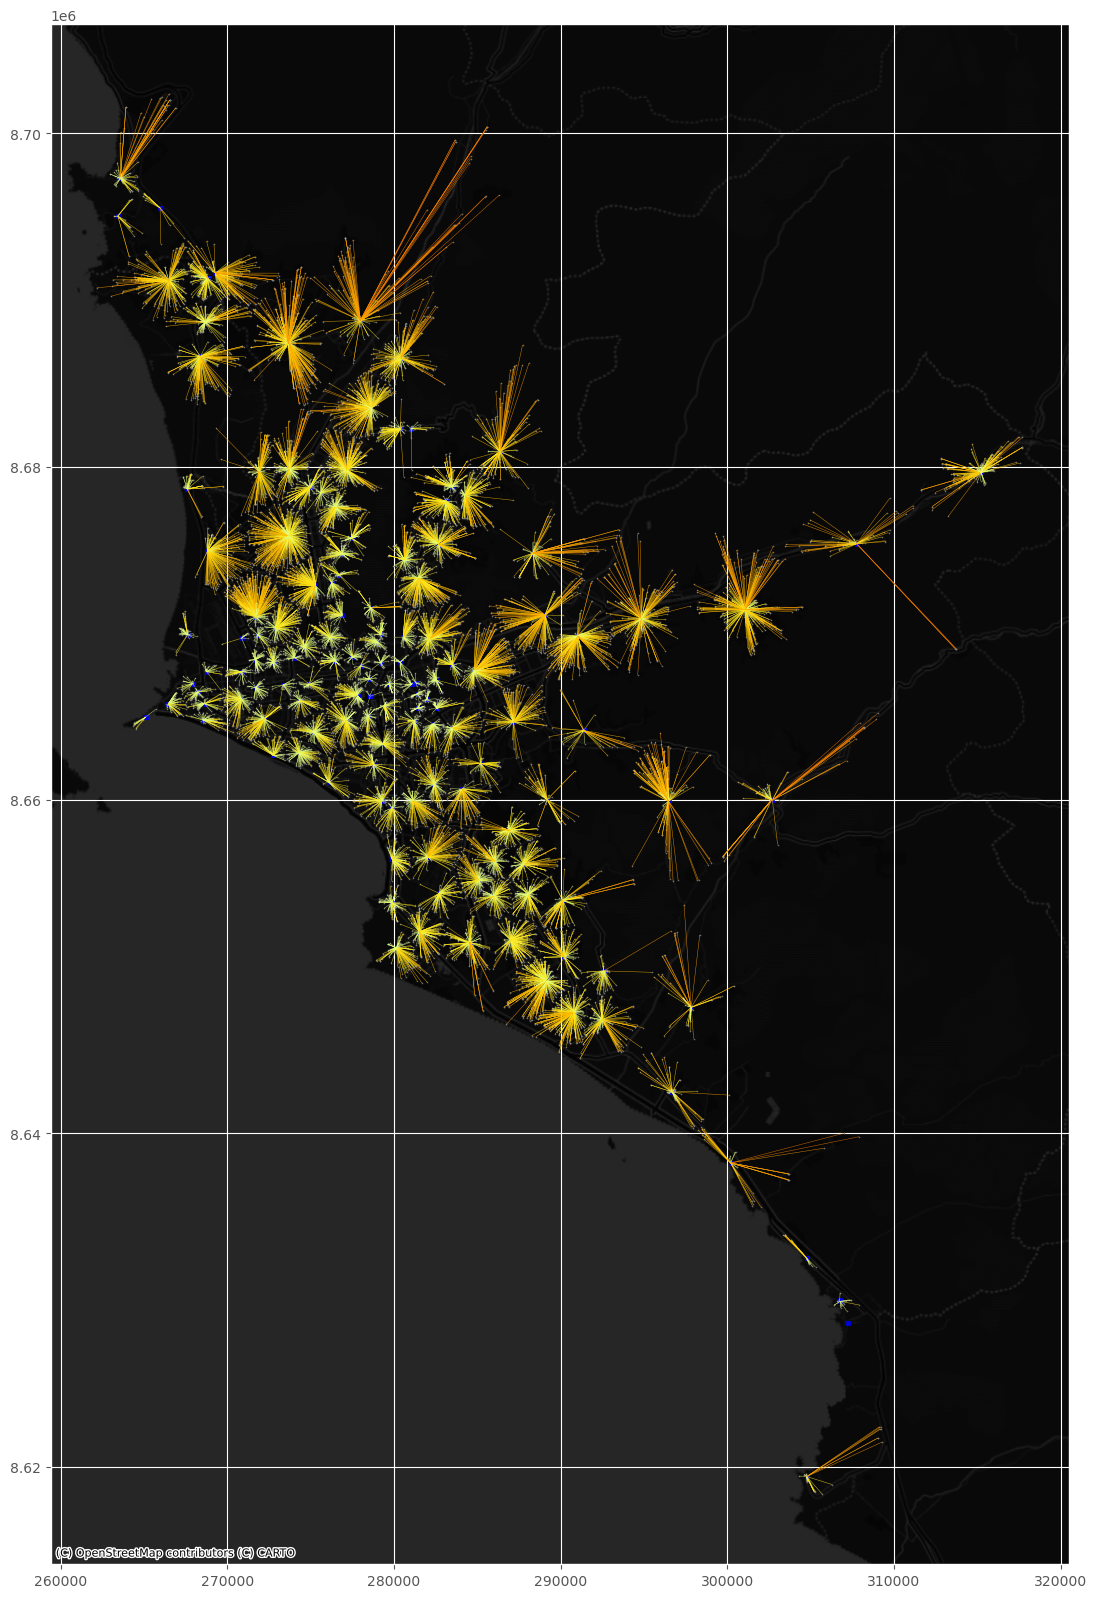

In [21]:
# Trazando las distancia, colegios y comisarias
fig, ax = plt.subplots(figsize=(20,20))

gdfNearLine.plot(ax=ax
                 , column='distancia'
                 , cmap='Wistia'
                 , scheme='natural_breaks'
                 , k=5
                 , alpha= 0.8
                 , lw=0.35
                )

gdfColLima.plot(ax=ax
                , color='gray'
                , markersize=0.5
                , alpha=0.7
               )

gdfComLima.plot(ax=ax
                , markersize=10
                , color='blue'
                , marker='s'
                , alpha=0.9
                )

# Agregar basemap
cx.add_basemap(ax
               , crs=gdfNearLine.crs.to_string()
               , source=cx.providers.CartoDB.DarkMatterNoLabels  
               )

plt.show()

Como se observa en el gráfico, las zonas periféricas tienden a presentar distancias promedio superiores al kilómetro entre colegios y comisarías. Este patrón resalta la importancia de idear estrategias específicas para mejorar la accesibilidad y la seguridad en estas áreas.

No obstante, para validar de manera más sólida esta suposición, se sugiere llevar a cabo estudios más detallados en estas zonas, abordando aspectos como el nivel delictivo y la peligrosidad. La inclusión de análisis más específicos permitirá llegar a conclusiones más certeras y respaldará de manera más completa las recomendaciones destinadas a optimizar la respuesta ante situaciones de emergencia y promover un entorno más seguro para la comunidad educativa en las zonas periféricas.

* **Elaborado por:** Charlie Lopez Rengifo
* **LinkedIN:** [chlopezgis](https://www.linkedin.com/in/chlopezgis/)
* **email:** chlopezgis@gmail.com